In [50]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import cv2
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from numba import jit
from pathlib import Path
from scipy.spatial import KDTree
#import tables

In [3]:
from dask import delayed
from dask.distributed import Client
import dask.array as da
import dask.dataframe as dd
#client = Client(n_workers=4)



In [6]:
#f = str((Path.home()) / '.nufeb_tools' / 'data' / 'Run_60_18_63_1_2021-06-23/trajectory.h5')

In [7]:
#xd= da.from_array(x.h5, chunks='auto')
#ddfs = dd.read_hdf(f,'/*')

#ddf = dd.concat(ddfs)

In [178]:
#x = utils.get_data(directory= r'D:\runs\Run_33_66_72_1_2021-06-24')

x = utils.get_data(test=True)

# Assign mother cells

In [179]:
df = x.positions
df['mother_cell'] = -1
for ID in df[df.Timestep==0].ID.unique():
    idx = df[df['ID'] ==ID].index
    df.loc[idx,'mother_cell'] = ID
df

,Timestep,ID,type,radius,x,y,z,mother_cell
0,0,75,2,4.465000e-07,0.000020,0.000023,9.400000e-07,75
1,0,50,1,8.200000e-07,0.000013,0.000016,2.140000e-06,50
2,0,19,1,8.400000e-07,0.000005,0.000008,2.680000e-06,19
3,0,59,1,8.950000e-07,0.000041,0.000016,3.310000e-06,59
4,0,42,1,7.200000e-07,0.000017,0.000006,6.170000e-06,42
...,...,...,...,...,...,...,...,...
43624,10000,297,2,4.548962e-07,0.000093,0.000084,9.540719e-06,-1
43625,10000,456,2,4.462032e-07,0.000095,0.000085,9.558846e-06,-1
43626,10000,202,2,4.359640e-07,0.000093,0.000085,9.569131e-06,-1
43627,10000,987,2,4.884362e-07,0.000093,0.000086,9.507520e-06,-1


In [180]:
arr = df[df.Timestep==1000][['x','y']].to_numpy()
tree = KDTree(arr)
dd, ii = tree.query(arr, k=2)
dd[:,1],ii[:,1]

(array([8.85268321e-06, 7.52109699e-06, 3.74076195e-06, 6.66108099e-06,
        4.14643220e-06, 1.02163790e-05, 3.74076195e-06, 4.14643220e-06,
        8.85268321e-06, 4.71699057e-06, 3.47850543e-06, 7.60000000e-06,
        6.85419580e-06, 2.92061637e-06, 3.47850543e-06, 9.31718842e-06,
        4.83290222e-07, 3.60583588e-06, 2.92061637e-06, 4.83290222e-07,
        1.84065277e-06, 7.85109603e-07, 4.83734311e-07, 7.85109603e-07,
        6.01177846e-06, 4.83734311e-07, 2.89870661e-06, 6.27994523e-06,
        1.46096316e-06, 8.19328994e-06, 1.04858901e-06, 1.46096316e-06,
        2.89870661e-06, 1.04858901e-06, 6.55133574e-06, 4.83290221e-07,
        2.97140868e-06, 5.58624203e-06, 4.83290221e-07, 7.43743397e-07,
        3.34215499e-06, 6.99004858e-06, 7.43743397e-07, 2.40831892e-06,
        1.41566239e-05, 6.46167860e-06, 2.40831892e-06, 7.15675896e-06,
        6.31981012e-06, 5.53624421e-06, 7.35459040e-06, 4.71699057e-06,
        4.83290222e-07, 1.00926954e-05, 7.41652884e-06, 1.459621

In [181]:
df[df.Timestep==1000].reset_index(drop=True).loc[ii[:,1],'ID'].values

array([44, 22, 15,  3, 22, 44, 19, 42, 75, 73,  7, 61, 24, 61, 40,  1, 84,
       84, 24, 20, 85, 85, 81, 32, 57, 51, 12, 81, 57, 60, 89, 82, 67, 14,
       48, 86, 69, 34, 37, 69, 48, 86, 79, 39,  2, 32, 48, 57, 70, 47, 17,
        3, 87, 56, 58, 41,  6, 56, 43, 88, 38, 36, 80, 66,  4, 10,  5, 80,
        9, 55, 68, 52, 76, 25,  4, 74, 39, 53, 71, 83, 27, 28,  8, 16,  8,
       30, 71, 16, 53])

In [182]:
df[(df['mother_cell'] ==-1) & (df.Timestep==1000)]
#s = pd.Series(ii[:,1],index=df[df.Timestep==1000].index)
s = pd.Series(df[df.Timestep==1000].reset_index(drop=True).loc[ii[:,1],'ID'].values)
idx = df[(df['mother_cell'] ==-1) & (df.Timestep==1000)].index
df.loc[idx,'mother_cell'] = s[(df['mother_cell'] ==-1) & (df.Timestep==1000)]
df[(df.Timestep==1000) & (df.ID != df.mother_cell)]

,Timestep,ID,type,radius,x,y,z,mother_cell
828,1000,84,1,8.232029e-07,0.000005,0.000030,0.000009,NaN
832,1000,85,1,8.058444e-07,0.000035,0.000071,0.000004,NaN
834,1000,81,1,8.319141e-07,0.000004,0.000057,0.000005,NaN
837,1000,82,1,8.235994e-07,0.000009,0.000067,0.000006,NaN
842,1000,89,1,7.338418e-07,0.000007,0.000063,0.000008,NaN
847,1000,86,1,8.232029e-07,0.000039,0.000085,0.000003,NaN
848,1000,79,2,3.760590e-07,0.000007,0.000087,0.000003,NaN
864,1000,88,1,8.149754e-07,0.000093,0.000016,0.000006,NaN
865,1000,87,1,8.232029e-07,0.000081,0.000019,0.000006,NaN
878,1000,80,1,8.449808e-07,0.000053,0.000053,0.000004,NaN


In [183]:
for time in df.Timestep.unique():
    arr = df[df.Timestep==time][['x','y']].to_numpy()
    tree = KDTree(arr)
    dd, ii = tree.query(arr, k=2)
    #s = pd.Series(ii[:,1],index=df[df.Timestep==time].index)
    s = pd.Series(df[df.Timestep==time].reset_index(drop=True).loc[ii[:,1],'ID'].values)
    idx = df[(df['mother_cell'] ==-1) & (df.Timestep==time)].index
    df.loc[idx,'mother_cell'] = s[(df['mother_cell'] ==-1) & (df.Timestep==time)]
df.mother_cell = df.mother_cell.astype('Int64')

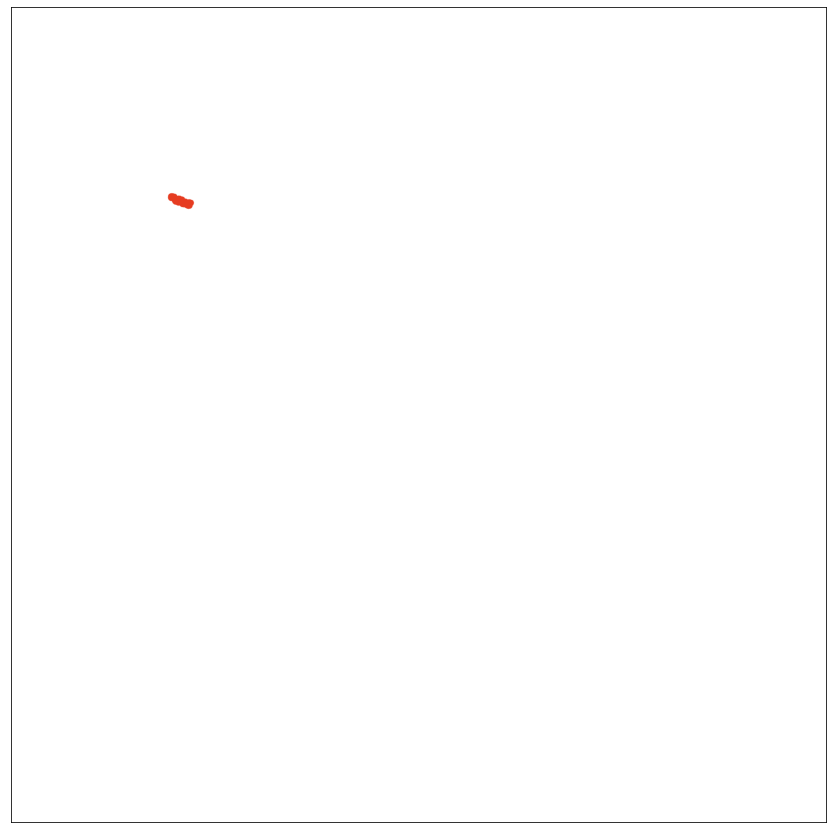

In [189]:
df[df.mother_cell==75]
scale = 1

img_size = 2000
bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
colors = tuple(np.random.randint(0,256, 3).astype('int'))

for cell in df[df.mother_cell==75].itertuples():
#print(cell)

    xloc = round(cell[5]/x.metadata['Dimensions'][0]*img_size)
    yloc = round(cell[6]/x.metadata['Dimensions'][1]*img_size)
    radius = round(cell[4]/x.metadata['Dimensions'][0]*img_size*scale)

    cv2.circle(bk,center = (xloc,yloc),radius = radius,color = (int(colors[0]),int(colors[1]),int(colors[2])),thickness = -1)
f, ax = plt.subplots(figsize=(15,15))
ax.imshow(bk)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
    #ax.set_axis_off()

In [190]:
df[df.mother_cell==-1]

,Timestep,ID,type,radius,x,y,z,mother_cell


In [191]:
#@jit(parallel=True)
def get_mothers(df,dataset):
    for time in df.Timestep.unique():
        tree = KDTree(df[df.Timestep==time][['x','y']].to_numpy())
        for cell in df[df.Timestep==time].ID:
            if df[df.ID==cell].head(1).mother_cell.isna().values[0]:
                cell_type = df[df.ID==cell].type.unique()[0]
                dist = dataset.get_neighbor_distance(cell,time)
                dist_type = dist[dist.type==cell_type]
                neighborID = dist_type[dist_type.Distance == dist_type.Distance.min()].ID.values[0]
                mother = df[df.ID==neighborID].head(1).mother_cell.values[0]
                mask = df[df.ID==cell]
                df.loc[mask.index,'mother_cell'] = mother
    df.mother_cell = df.mother_cell.astype('Int64')
    return df
#df2 = get_mothers(df,x)
#df2 = delayed(get_mothers) (df,x)

In [192]:
#df2.compute()

In [197]:

def plot_colony(df):
    timepoint = 5000
    scale = 1
    tp = df[df.Timestep == timepoint]
    img_size = 2000
    bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)

    N = 100
    red = np.ones((N, 3))
    red[:, 0] = 255
    red[:, 1] = np.linspace(0, 255,N,dtype=int)
    red[:, 2] = np.linspace(65, 255,N,dtype=int)

    green = np.ones((N, 3))
    green[:, 0] = np.linspace(65, 255,N,dtype=int)
    green[:, 2] = np.linspace(0, 255,N,dtype=int)
    green[:, 1] = 255

    for i, colony in enumerate(tp.mother_cell.unique()):
        colony_type = tp[tp.mother_cell==colony].type
        colors = tuple(np.random.randint(0,256, 3).astype('int'))
        if not colony_type.empty:
            #if colony_type.unique()[0] == 1:

                #colors = green
            #elif colony_type.unique()[0] == 2:
            #print(colony)
                #colors = red
            for cell in tp[tp.mother_cell==colony].itertuples():
                #print(cell)
                
                xloc = round(cell[5]/x.metadata['Dimensions'][0]*img_size)
                yloc = round(cell[6]/x.metadata['Dimensions'][1]*img_size)
                radius = round(cell[4]/x.metadata['Dimensions'][0]*img_size*scale)
                
                cv2.circle(bk,center = (xloc,yloc),radius = radius,color = (int(colors[0]),int(colors[1]),int(colors[2])),thickness = -1)
    f, ax = plt.subplots(figsize=(15,15))
    ax.imshow(bk)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #ax.set_axis_off()


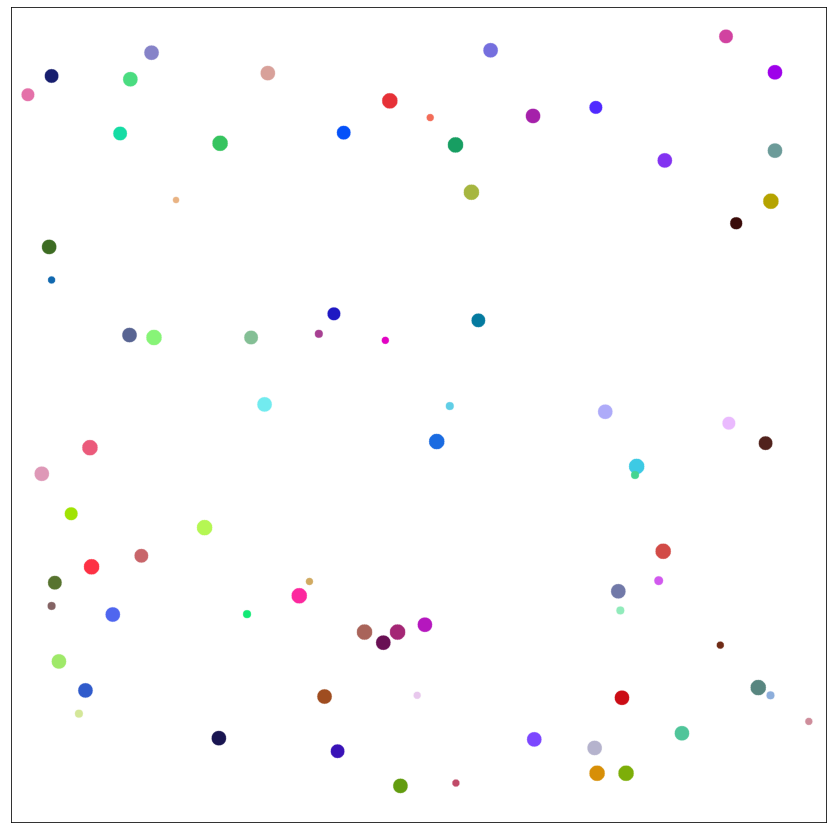

In [198]:
plot_colony(df)